# EELS SrFeO Project 
## RNN Autoencoder

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on RNN Autoencoder

* // put resources here //

### Import Package

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False

### Loading Data

### Flatten Data

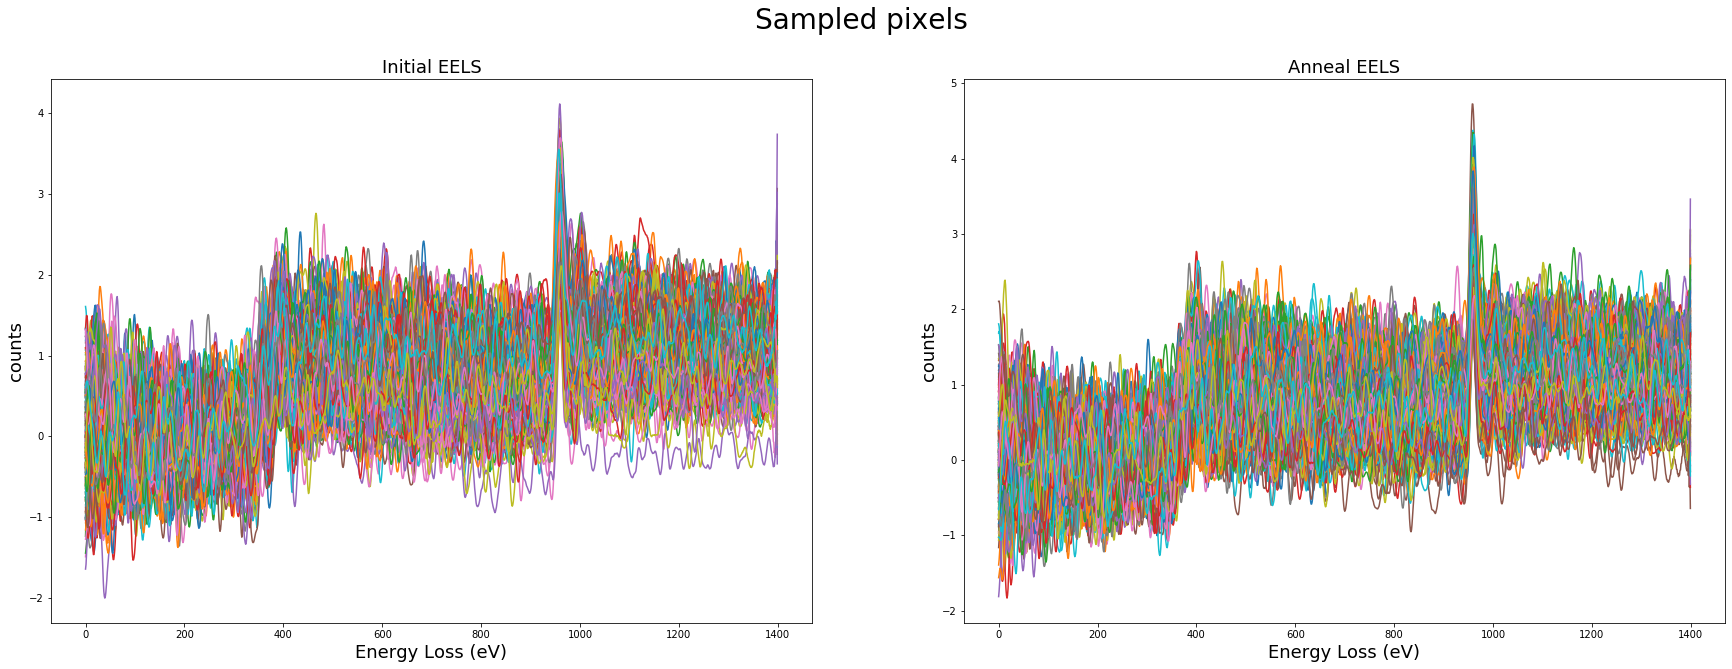

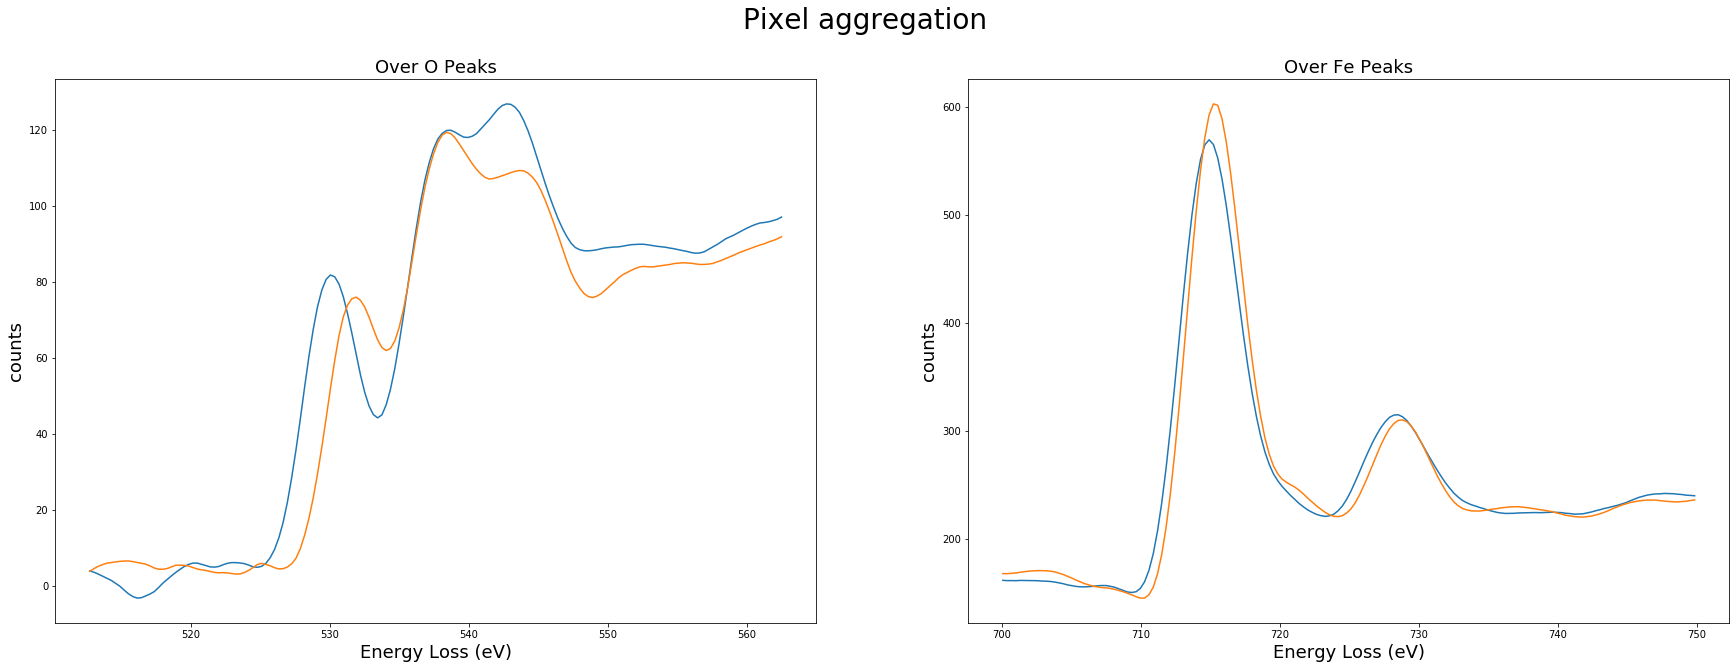

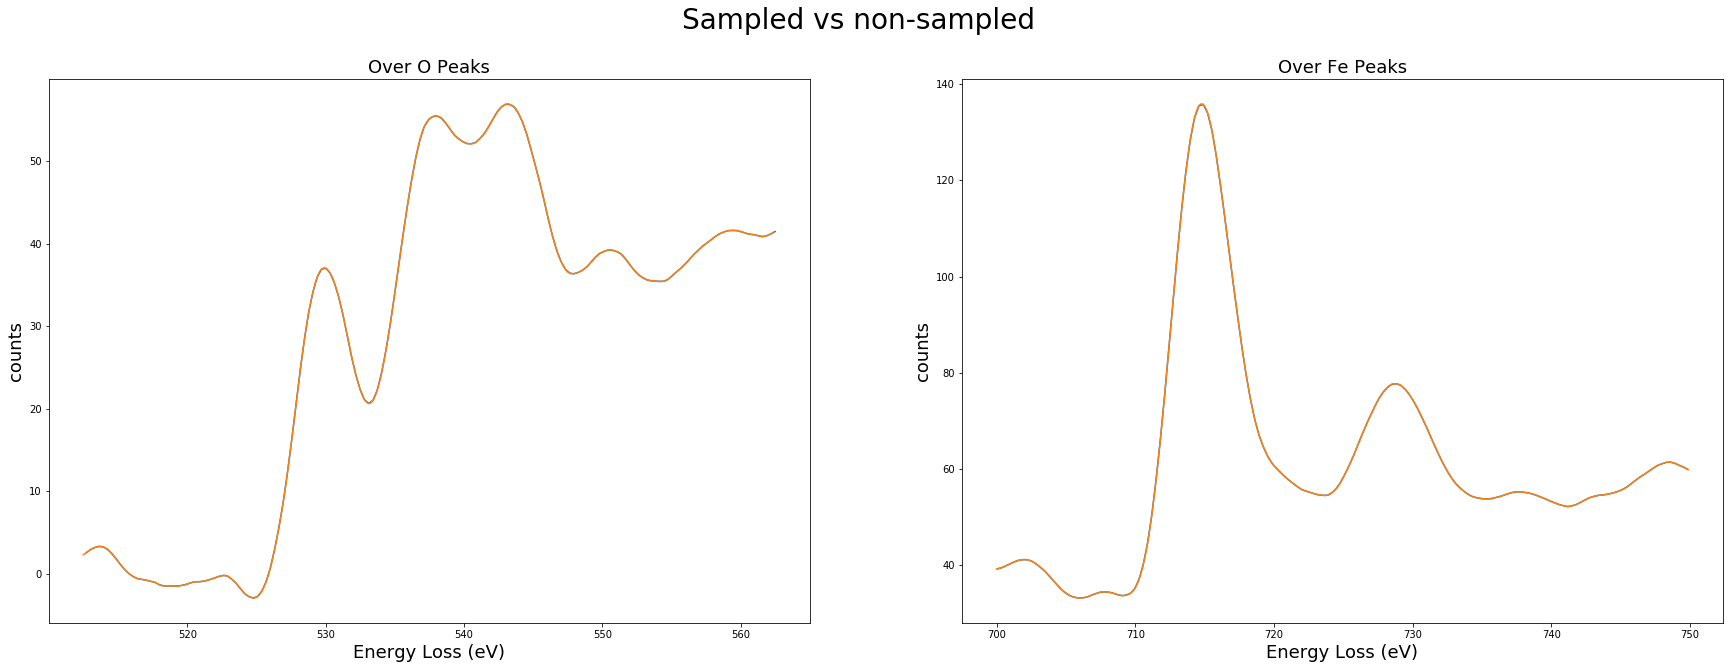

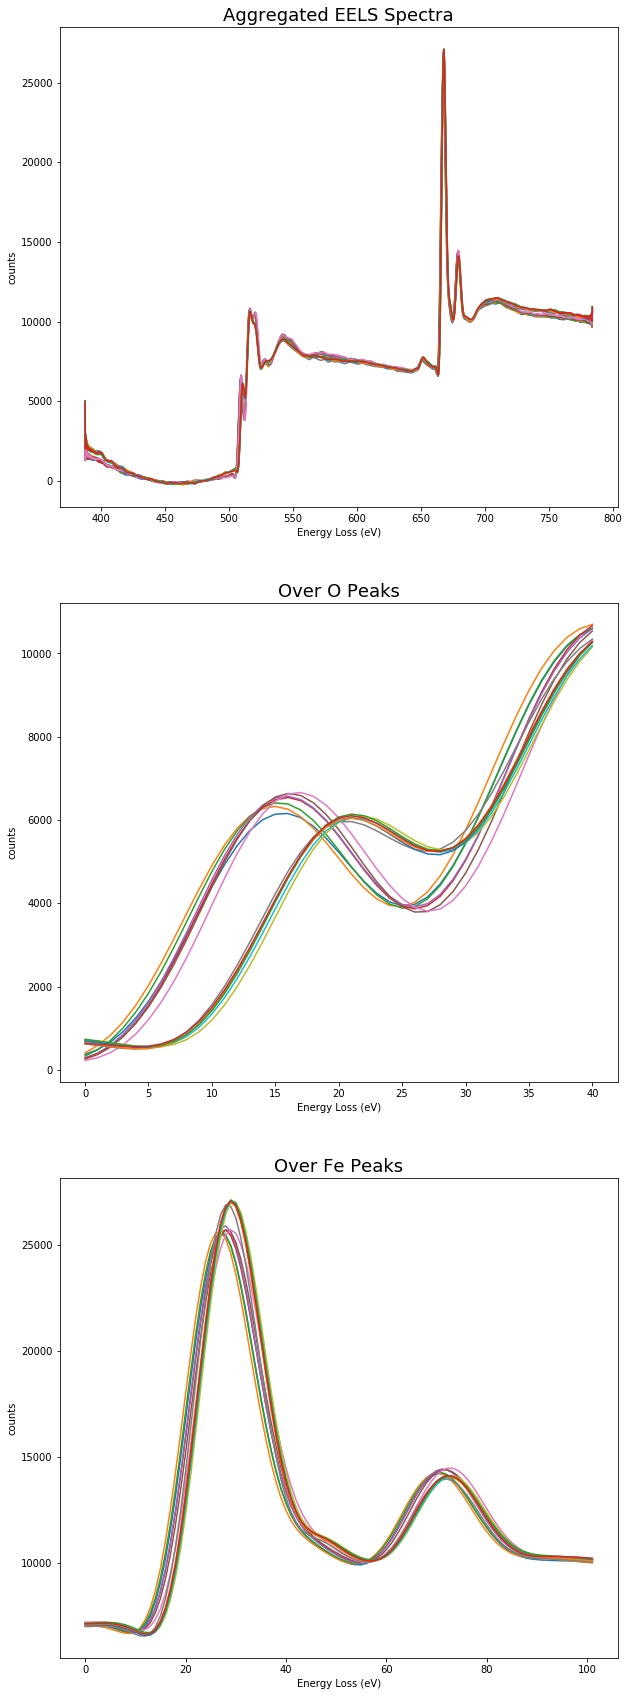

(180000, 41)
(180000, 2)


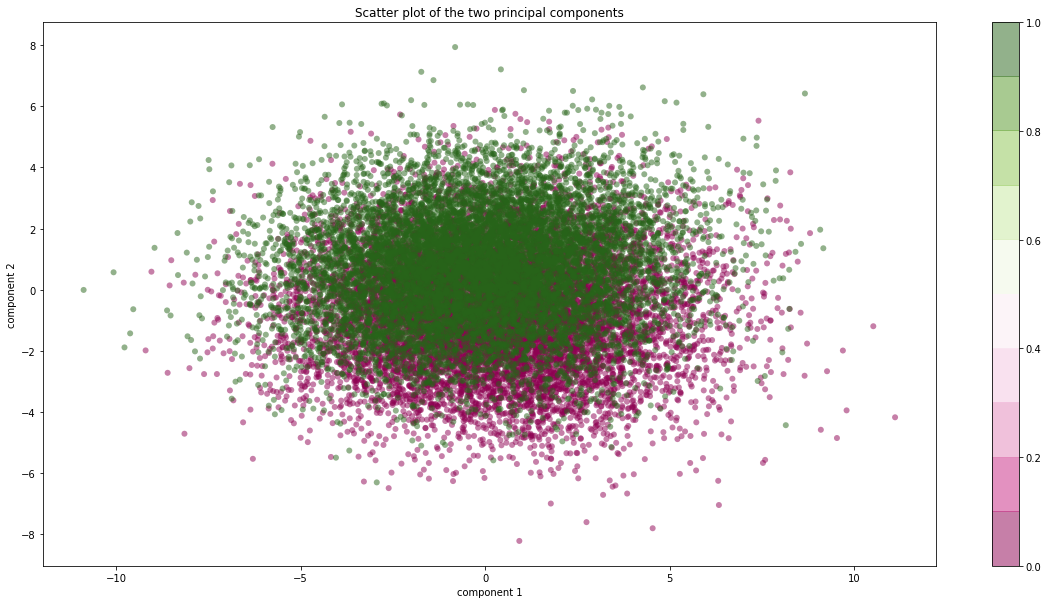

SyntaxError: invalid syntax (<ipython-input-3-0369e354992b>, line 6)

In [3]:
%run ./1_DataPrep.ipynb

In [4]:
data_ana.shape

(180000, 41)

## Recurrent Neural Network 

### Setting up autoencoder

In [5]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

Using TensorFlow backend.


In [6]:
def rnn_autoencoder(layer, size, N_encode, 
                    N_decode, embed, 
                    N_steps, lr = 3e-6, drop_frac = 0.89,
                    bidir = False, l1_norm = 1e-4, **kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    N_encode  : numpy, int
        sets the number of encoding layers in the network
    N_decode : numpy, int
        sets the number of decoding layers in the network
    embed : numpy, int
        sets the size of the embedding layer
    N_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidir : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    model = Sequential()
    
    # wrapper for bidirectional LSTM
    if bidir: wrapper = Bidirectional
    else: wrapper = lambda x: x
        
        
    # builds the first layer
    model.add(wrapper(layer(size, return_sequences=(N_encode > 1),  dropout=drop_frac, input_shape=(n_step, 1))))

    # builds the encoding layers
    for i in range(1, N_encode):
        model.add(wrapper(layer(size, return_sequences=(i < N_encode - 1), dropout=drop_frac)))

    # builds the embedding layer
    model.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(N_steps))

    # builds the decoding layer
    for i in range(N_decode):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

In [7]:
def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. 
        It is however limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                 verbose=0, save_best_only=True,
                                                 save_weights_only=True, 
                                                 mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_test), 
              epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], 
              validation_data=(np.atleast_3d(data_train), np.atleast_3d(data_test)))

### Training Autoencoder

In [12]:
# construct a model
model = rnn_autoencoder(LSTM, 41, 3, 3, 16, 41)

In [158]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
encoding (Dense)             (None, 16)                2064      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 48, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 128)           74240     
_________________________________________________________________
lstm_4 (LSTM)                (None, 48, 128)          

In [ ]:
folder_name = 'rnn_auto_checkpoints'
train_model(model, data_ana, data_ana, folder_name, epochs=10, batch_size=200)

Train on 180000 samples, validate on 180000 samples
Epoch 1/25000
180000/180000 [==============================] - 252s 1ms/step - loss: 0.6371 - val_loss: 0.5364
Epoch 2/25000
180000/180000 [==============================] - 250s 1ms/step - loss: 0.4970 - val_loss: 0.4383
Epoch 3/25000
180000/180000 [==============================] - 250s 1ms/step - loss: 0.3906 - val_loss: 0.3682
Epoch 4/25000
180000/180000 [==============================] - 250s 1ms/step - loss: 0.3535 - val_loss: 0.3393
Epoch 5/25000
180000/180000 [==============================] - 250s 1ms/step - loss: 0.3248 - val_loss: 0.3100
Epoch 6/25000
180000/180000 [==============================] - 249s 1ms/step - loss: 0.2942 - val_loss: 0.2776
Epoch 7/25000
180000/180000 [==============================] - 250s 1ms/step - loss: 0.2603 - val_loss: 0.2439
Epoch 8/25000
180000/180000 [==============================] - 250s 1ms/step - loss: 0.2307 - val_loss: 0.2187
Epoch 9/25000
180000/180000 [==============================]

### <span style="color:blue"> Training may take a few days depending on epochs. </span>
    At this point, just let the training run in the background. 
    Go to the next notebook to analyze the trained results.